# CHIPPR

This notebook demonstrates the use of the Cosmological Hierarchical Inference with Probabilistic Photometric Redshifts (CHIPPR) package to estimate the redshift density function.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit

import chippr
from chippr import *

In [19]:
help(chippr)

Help on package chippr:

NAME
    chippr

FILE
    /Users/aimalz/anaconda/lib/python2.7/site-packages/chippr-0.1-py2.7.egg/chippr/__init__.py

PACKAGE CONTENTS
    catalog
    discrete
    gauss
    gmix
    int_pr_fun
    interim_prior
    lik_fun
    likelihood
    log_z_dens
    plot_utils
    post_fun
    posterior
    sim
    sim_utils
    utils
    z_dens

SUBMODULES
    pu
    su
    u

DATA
    __loader__ = <zipimporter object "/Users/aimalz/anaconda/lib/python2.7...
    a_int = 0.5
    a_mle = 1.0
    a_stk = 1.0
    a_tru = 1.0
    c_int = 'k'
    c_mle = 'k'
    c_stk = 'k'
    c_tru = 'k'
    d_int = [(0, (1, 0.0001))]
    d_mle = [(0, (1, 1))]
    d_stk = [(0, (3, 2))]
    d_tru = [(0, (1, 0.0001))]
    eps = 2.220446049250313e-16
    l_int = 'Interim '
    l_mle = 'MMLE '
    l_stk = 'Stacked '
    l_tru = 'True '
    lnz = r'$\ln[n(z)]$'
    nz = '$n(z)$'
    s_int = '--'
    s_mle = '--'
    s_stk = '--'
    s_tru = '--'
    w_int = 0.5
    w_mle = 2.0
    w_stk = 1.5
 

## Simulation

In [20]:
tru_amps = np.array([0.20, 0.35, 0.55])
tru_means = np.array([0.5, 0.2, 0.75])
tru_sigmas = np.array([0.4, 0.2, 0.1])

tru_nz = gmix(tru_amps, tru_means, tru_sigmas, limits=(0., 1.))

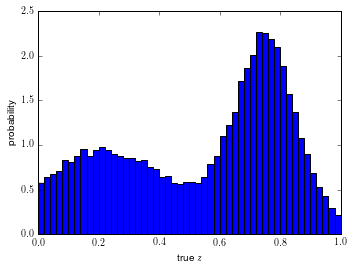

In [21]:
N = 2**16

tru_zs = tru_nz.sample(N)

plt.hist(tru_zs, bins=50, normed=1)
plt.xlabel(r'true $z$')
plt.ylabel(r'probability')

In [22]:
params = {}

In [23]:
lf_sigma = 0.05

params['constant_sigma'] = lf_sigma

In [24]:
bin_ends = np.array([0., 1.])
weights = np.array([1.])

int_prior = discrete(bin_ends, weights)

In [29]:
posteriors = catalog(params)

start_time = timeit.default_timer()

output = posteriors.create(tru_zs, int_prior, bins=16)

data = output['interim_posteriors']

elapsed = timeit.default_timer() - start_time
print(elapsed)

{'constant_sigma': 0.05}
(array([  6.23436369e-09,   6.24987433e-02,   1.24997480e-01,
         1.87496218e-01,   2.49994955e-01,   3.12493692e-01,
         3.74992429e-01,   4.37491166e-01,   4.99989903e-01,
         5.62488640e-01,   6.24987377e-01,   6.87486114e-01,
         7.49984851e-01,   8.12483588e-01,   8.74982325e-01,
         9.37481063e-01,   9.99979800e-01]), (17,))
292.299290895


In [ ]:
for datum in data[:10]:
    plt.plot(posteriors.x_coarse, datum)
plt.plot(posteriors.x_coarse, int_prior.evaluate(posteriors.x_coarse), color='k')

In [ ]:
for n, z in enumerate(data[:10]):
    plt.plot(posteriors.x_coarse, data[n], 'ko')
    plt.plot(posteriors.x_fine, posteriors.obs_lfs[n], 'k-')
    plt.show()

## Inference

In [ ]:
# data_loc = '../../../prob-z/nz/code/tests/sig2/data/logdata.csv'

# with open(data_loc,'rb') as data_file:
#     tuples = (line.split(None) for line in data_file)
#     data = [[float(pair[k]) for k in range(0,len(pair))] for pair in tuples]

In [ ]:
zs = output['bin_ends']
nz_intp = output['interim_prior']
z_posts = data

print(np.shape(zs), np.shape(nz_intp), np.shape(z_posts))

z_mids = (zs[1:]+zs[:-1])/2.
n_bins = len(z_mids)

In [ ]:
prior_sigma = 0.16
prior_var = np.eye(n_bins)
for b in range(n_bins):
    prior_var[b] = 1. * np.exp(-0.5 * (z_mids[b] - z_mids) ** 2 / prior_sigma ** 2)
l = 1.e-4
prior_var = prior_var+l*np.identity(n_bins)

prior_mean = nz_intp
prior = gauss(prior_mean, prior_var)

In [ ]:
nz = log_z_dens(output, prior, truth=tru_nz, vb=True)

In [ ]:
nz_mmle = nz.optimize(np.log(nz_intp))

In [ ]:
nz.plot()

In [ ]:
nz_stack = nz.stack()

In [ ]:
nz_mmap = nz.mmap()

In [ ]:
nz_mexp = nz.mexp()

In [ ]:
#nz_samps = nz.sample()